# Openpose simple demo

In [1]:
%matplotlib inline
import math
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import config
import connections
import coordinates
import estimators
import util
import torch
from models.cmu_model_torch import CmuModel

## step 0：read trained model

use trained model and use a test image to predict

In [2]:
model_path = 'models/body_full.pth'
model = CmuModel()
if torch.cuda.is_available():
    model = model.cuda()
model.load_state_dict(torch.load(model_path))
model.eval()

CmuModel(
  (model0): Sequential(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv1_1): ReLU(inplace=True)
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv1_2): ReLU(inplace=True)
    (pool1_stage1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv2_1): ReLU(inplace=True)
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv2_2): ReLU(inplace=True)
    (pool2_stage1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv3_1): ReLU(inplace=True)
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv3_2): ReLU(inplace=True)
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3)

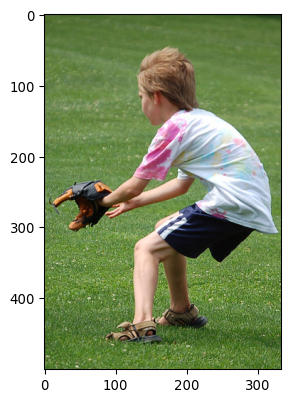

In [3]:
test_img = 'demo.jpg' # Image path here
oriImg = cv2.imread(test_img) # B,G,R order
plt.imshow(oriImg[:,:,[2,1,0]])
fig = plt.gcf()
fig.set_dpi(96)

## step 1：exstract Heatmap and PAF

In [4]:
inp_size = 368  # input size
stride = 8  # output map size
padValue = 128
thre1 = 0.1
thre2 = 0.05
scale_factors = [0.5, 1, 1.5, 2]

heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))
multipliers = [x * inp_size / oriImg.shape[0] for x in scale_factors] 

for m, scale in enumerate(multipliers):
    imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    imageToTest_padded, pad = util.pad_right_down_corner(imageToTest, stride, padValue)
    # Pytorch requires (1, channels, width, height)
    im = np.transpose(np.float32(imageToTest_padded[:, :, :, np.newaxis]), (3, 2, 0, 1)) / 256 - 0.5
    print("Input shape: " + str(im.shape))
    
    data = torch.from_numpy(im).float()
    if torch.cuda.is_available():
        data = data.cuda()
    with torch.no_grad():
        Mconv7_stage6_L1, Mconv7_stage6_L2 = model(data)
    Mconv7_stage6_L1 = Mconv7_stage6_L1.cpu().numpy()
    Mconv7_stage6_L2 = Mconv7_stage6_L2.cpu().numpy()
    
    print("Output shape (heatmap): " + str(Mconv7_stage6_L2.shape))
    print("Output shape (paf): " + str(Mconv7_stage6_L1.shape))
    
    # extract outputs, resize, and remove padding
    # output 1 is heatmaps
    heatmap = np.transpose(np.squeeze(Mconv7_stage6_L2), (1, 2, 0))
    heatmap = cv2.resize(heatmap, (0,0), fx=stride, fy=stride, interpolation=cv2.INTER_CUBIC)
    heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]  # 去除填充
    heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    # output 0 is PAFs
    paf = np.transpose(np.squeeze(Mconv7_stage6_L1), (1, 2, 0))
    paf = cv2.resize(paf, (0,0), fx=stride, fy=stride, interpolation=cv2.INTER_CUBIC)
    paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    heatmap_avg = heatmap_avg + heatmap / len(multipliers)
    paf_avg = paf_avg + paf / len(multipliers)


Input shape: (1, 3, 184, 128)
Output shape (heatmap): (1, 19, 23, 16)
Output shape (paf): (1, 38, 23, 16)
Input shape: (1, 3, 368, 248)
Output shape (heatmap): (1, 19, 46, 31)
Output shape (paf): (1, 38, 46, 31)
Input shape: (1, 3, 552, 368)
Output shape (heatmap): (1, 19, 69, 46)
Output shape (paf): (1, 38, 69, 46)
Input shape: (1, 3, 736, 496)
Output shape (heatmap): (1, 19, 92, 62)
Output shape (paf): (1, 38, 92, 62)


## step 2：extract body

Here we use a config class to define all identifiable limb parts and possible connections between them. Then use get_coordinates to obtain all possible extreme points in the Heatmap (compared with the adjacent pixels up, down, left, and right to get the maximum value), then combine the PAF graph in get_connections to calculate the E value of the connection between different nodes, and finally press E in estimators Values from high to low connect these spliced limbs into a whole.

In [5]:
cfg = config.get_default_configuration()
coords = coordinates.get_coordinates(cfg, heatmap_avg, thre1)
conns = connections.get_connections(cfg, coords, paf_avg, thre2)
skeletons = estimators.estimate(cfg, conns)

print('coordinates: ')
print(coords)
print('connections: ')
print(conns)
print('skeletons: ')
print(skeletons)

coordinates: 
{'nose': [(135, 122, 0.5944058150053024, 0)], 'neck': [(200, 152, 0.6057457774877548, 1)], 'right_shoulder': [(216, 144, 0.44415753707289696, 2)], 'right_elbow': [(192, 238, 0.7984612435102463, 3)], 'right_wrist': [(121, 266, 0.7466518133878708, 4)], 'left_shoulder': [(184, 158, 0.6023019179701805, 5)], 'left_elbow': [(124, 245, 0.6988532766699791, 6)], 'left_wrist': [(85, 262, 0.6497820317745209, 7)], 'right_hip': [(291, 256, 0.24260285776108503, 8)], 'right_knee': [(181, 327, 0.47595667839050293, 9), (245, 338, 0.12993605214433046, 10)], 'right_ankle': [(192, 415, 0.7243724912405014, 11)], 'left_hip': [(272, 262, 0.37481758557260036, 12)], 'left_knee': [(164, 299, 0.22459888877347112, 13), (141, 329, 0.8086650669574738, 14)], 'left_ankle': [(139, 430, 0.6029957309365273, 15)], 'right_eye': [], 'left_eye': [(137, 114, 0.8062357157468796, 16)], 'right_ear': [], 'left_ear': [(157, 115, 0.9154846519231796, 17)]}
connections: 
[array([[1.        , 2.        , 0.60574578, 0.4

## step 3：visualization result

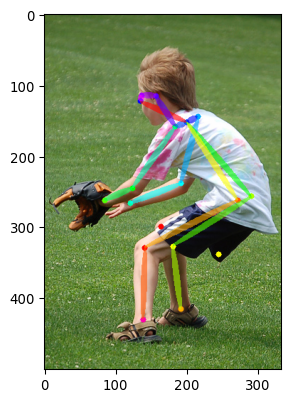

In [6]:
canvas = util.draw(cfg, oriImg, coords, skeletons)
plt.imshow(canvas[:, :, [2, 1, 0]])
fig = plt.gcf()
fig.set_dpi(96)